In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
pd.options.display.float_format = '{:,.2f}'.format


'''Функция построения "ящиков с усами"'''
def data_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Распределение баллов по госэкзамену по математике в зависимости от параметра ' + column)
    plt.show()

    
'''Функция проверки статистическолй разницы в распределении оценок по номинативным признакам с помощью теста Стьюдента'''
def data_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для параметра', column)
            break
    else: print('Статистически значимые различия для параметра', column, 'не найдены')
        

stud_math = pd.read_csv('stud_math.csv')

## Проверяем считываемость данных, смотрим, какие данные хранятся в файле, выводим название столбцов

In [2]:
display(stud_math.head())
stud_math.columns

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.00,4.00,at_home,teacher,course,mother,2.00,2.00,0.00,yes,no,no,no,yes,-6.00,yes,NaN,no,4.00,3.00,4.00,3.00,6.00,30.00
1,GP,F,17,U,GT3,NaN,1.00,1.00,at_home,other,course,father,1.00,2.00,0.00,no,yes,no,no,no,-6.00,yes,yes,no,5.00,3.00,3.00,3.00,4.00,30.00
2,GP,F,15,U,LE3,T,1.00,1.00,at_home,other,other,mother,1.00,2.00,3.00,yes,no,NaN,no,yes,-6.00,yes,yes,NaN,4.00,3.00,2.00,3.00,10.00,50.00
3,GP,F,15,U,GT3,T,4.00,2.00,health,NaN,home,mother,1.00,3.00,0.00,no,yes,yes,yes,yes,-9.00,yes,yes,yes,3.00,2.00,2.00,5.00,2.00,75.00
4,GP,F,16,U,GT3,T,3.00,3.00,other,other,home,father,1.00,2.00,0.00,no,yes,yes,no,yes,-6.00,yes,no,no,4.00,3.00,2.00,5.00,4.00,50.00


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

## Для удобства использования частично заменям название столбцов, выводим для проверки таблицу и информацию о данных для первичного анализа

In [3]:
'''Для удобства использования частично заменям название столбцов'''
stud_math.rename(columns={'famsize': 'fam_size', 'Pstatus': 'p_status', 'Medu': 'm_edu', 'Fedu': 'f_edu', 
                 'Mjob': 'm_job', 'Fjob': 'f_job', 'traveltime': 'travel_time', 'studytime': 'study_time', 
                 'schoolsup': 'school_sup', 'famsup': 'fam_sup','studytime, granular': 'std_time_gnr', 
                 'famrel': 'fam_rel', 'freetime': 'free_time','goout': 'go_out'}, inplace=True)

In [4]:
display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,std_time_gnr,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.00,4.00,at_home,teacher,course,mother,2.00,2.00,0.00,yes,no,no,no,yes,-6.00,yes,NaN,no,4.00,3.00,4.00,3.00,6.00,30.00
1,GP,F,17,U,GT3,NaN,1.00,1.00,at_home,other,course,father,1.00,2.00,0.00,no,yes,no,no,no,-6.00,yes,yes,no,5.00,3.00,3.00,3.00,4.00,30.00
2,GP,F,15,U,LE3,T,1.00,1.00,at_home,other,other,mother,1.00,2.00,3.00,yes,no,NaN,no,yes,-6.00,yes,yes,NaN,4.00,3.00,2.00,3.00,10.00,50.00
3,GP,F,15,U,GT3,T,4.00,2.00,health,NaN,home,mother,1.00,3.00,0.00,no,yes,yes,yes,yes,-9.00,yes,yes,yes,3.00,2.00,2.00,5.00,2.00,75.00
4,GP,F,16,U,GT3,T,3.00,3.00,other,other,home,father,1.00,2.00,0.00,no,yes,yes,no,yes,-6.00,yes,no,no,4.00,3.00,2.00,5.00,4.00,50.00
5,GP,M,16,U,LE3,T,4.00,3.00,services,other,reputation,mother,1.00,2.00,0.00,no,yes,yes,yes,yes,-6.00,yes,yes,no,5.00,4.00,2.00,5.00,10.00,75.00
6,GP,M,16,NaN,LE3,T,2.00,2.00,other,other,home,mother,1.00,2.00,0.00,no,no,no,no,yes,-6.00,yes,yes,no,4.00,4.00,4.00,3.00,0.00,55.00
7,GP,F,17,U,GT3,A,4.00,4.00,other,teacher,home,mother,2.00,2.00,0.00,yes,yes,no,no,yes,-6.00,yes,no,no,4.00,1.00,4.00,1.00,6.00,30.00
8,GP,M,15,U,LE3,A,3.00,2.00,services,other,home,mother,1.00,2.00,0.00,no,yes,yes,no,yes,-6.00,yes,yes,no,nan,2.00,2.00,1.00,0.00,95.00
9,GP,M,15,U,NaN,NaN,3.00,4.00,other,other,home,mother,1.00,2.00,0.00,no,yes,yes,yes,yes,-6.00,yes,yes,no,5.00,5.00,1.00,5.00,0.00,75.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   school        395 non-null    object 
 1   sex           395 non-null    object 
 2   age           395 non-null    int64  
 3   address       378 non-null    object 
 4   fam_size      368 non-null    object 
 5   p_status      350 non-null    object 
 6   m_edu         392 non-null    float64
 7   f_edu         371 non-null    float64
 8   m_job         376 non-null    object 
 9   f_job         359 non-null    object 
 10  reason        378 non-null    object 
 11  guardian      364 non-null    object 
 12  travel_time   367 non-null    float64
 13  study_time    388 non-null    float64
 14  failures      373 non-null    float64
 15  school_sup    386 non-null    object 
 16  fam_sup       356 non-null    object 
 17  paid          355 non-null    object 
 18  activities    381 non-null    

In [5]:
'''Расчёт количества пропущенных значений в столбцах'''
i = 0
print('Количество пропущенных значений в столбцах:')
for column in stud_math.columns:
    i += 1
    print(i, column, '-', stud_math.loc[:, column].isnull().sum())

Количество пропущенных значений в столбцах:
1 school - 0
2 sex - 0
3 age - 0
4 address - 17
5 fam_size - 27
6 p_status - 45
7 m_edu - 3
8 f_edu - 24
9 m_job - 19
10 f_job - 36
11 reason - 17
12 guardian - 31
13 travel_time - 28
14 study_time - 7
15 failures - 22
16 school_sup - 9
17 fam_sup - 39
18 paid - 40
19 activities - 14
20 nursery - 16
21 std_time_gnr - 7
22 higher - 20
23 internet - 34
24 romantic - 31
25 fam_rel - 27
26 free_time - 11
27 go_out - 8
28 health - 15
29 absences - 12
30 score - 6


In [6]:
'''Расчёт уникальных значений в столбцах номинативных переменных'''
print('Уникальных значений в столбцах номинативных переменных:')
i = 0
for clmn in stud_math.columns:
    if stud_math.loc[:, clmn].dtype == 'O':
        i += 1
        print(i, clmn, '-', stud_math.loc[:, clmn].nunique())

Уникальных значений в столбцах номинативных переменных:
1 school - 2
2 sex - 2
3 address - 2
4 fam_size - 2
5 p_status - 2
6 m_job - 5
7 f_job - 5
8 reason - 4
9 guardian - 3
10 school_sup - 2
11 fam_sup - 2
12 paid - 2
13 activities - 2
14 nursery - 2
15 higher - 2
16 internet - 2
17 romantic - 2


#### Таким образом, в датасете находятся записи по 395 учащимся. Датасет состоит 30 столбцов: 13 числовых и 17 строковых. Полностью заполнены только три первых столбца (школа, пол и возраст), остальные имеют пропуски
##  

## ЭТАП 1
## Анализ  количественных показателей

Количество пропущенных значений: 6


'Количественные показатели:'

50.00     54
55.00     46
0.00      37
75.00     33
65.00     31
40.00     31
60.00     31
70.00     27
45.00     27
80.00     16
30.00     15
90.00     12
35.00      9
25.00      7
85.00      6
95.00      5
100.00     1
20.00      1
Name: score, dtype: int64

'Статистические показатели:'

count   389.00
mean     52.26
std      22.92
min       0.00
25%      40.00
50%      55.00
75%      70.00
max     100.00
Name: score, dtype: float64

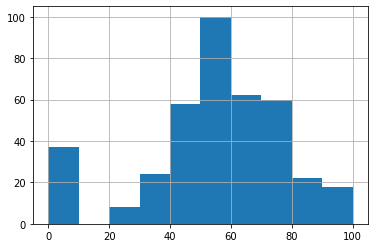

In [7]:
'''Проверка показателей параметра score (баллы по госэкзамену по математике)'''
print('Количество пропущенных значений:',stud_math.score.isnull().sum())
display('Количественные показатели:', stud_math.score.value_counts())
display('Статистические показатели:', stud_math.score.describe())
stud_math.score.hist()

### Первоначальный анализ показывает, что данные достаточно полные, имеется всего 6 пропущенных значений, выбросы отсутствуют

#### Таким образом, у 43 учеников итоговый балл по математике равен "нулю". Крайне маловероятно, что  11% учеников сдавали экзамен и получили "нулевую" оценку. Хотя бы 1 балл, но они должны были набрать (ну, не тупые же они совсем!!!). При этом мы видим, что самый "неуспешный" ученик набрал минимум 20 баллов. Если дополнительно проанализировать информацию о "нулевых" учениках, то  мы увидим, что большинство из них не пропускали занятия и хотят получить высшее образование. Из этого можно сделать вывод, что, скорее всего, данные ученики либо ещё не сдавали госэкзамен (что вероятнее всего), либо их результаты ещё не заненсены в таблицу . В любом случае, мы не должны брать данных учеников в расчёт, и они должны быть исключены из дальнейшего анализа, так как мы оцениваем влияние условий жизни учащихся на их успеваемость, а при отсутствии успеваемости данное влияние мы проверить не сможем (теряется физический смысл работы). 

### Гистограмма похожа на симметричную ("нормальную") форму распределения с выбросом в районе нуля. Однако, данный "выброс" укладывается в интервал "25% квартиль - 1,5 межквартильного расстояния" (40-(70-40)*1,5 = -5), и теоретически этот "выброс" мы должны брать в обработку. Теперь построим гистограмму успеваемости без учеников, имеющих "нулевые" оценки:

count   352.00
mean     57.76
std      16.20
min      20.00
25%      45.00
50%      55.00
75%      70.00
max     100.00
Name: score, dtype: float64

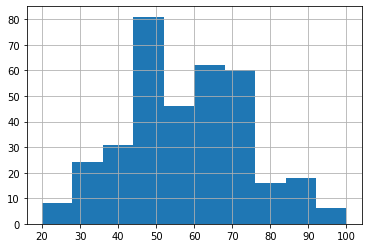

In [8]:
stud_math.score[stud_math.score>0].hist()
stud_math.score[stud_math.score>0].describe()

### Получили похожую на симметричную бимодальную форму распределения, при этом "нулевые" оценки уже выходят за рамки "percentile(25) -1.5*IQR" (45 -(70-45)**1,5 = 7,5) и могут классифицироваться, как выбросы. Данный подход не совсем корректен с точки зрения математики, однако, имеет право быть с точки зрения здравого смысла

### Посмотрим, объединяет ли что-нибудь учеников, имеющие "нулевые" отметки по математике:

In [9]:
display(stud_math[stud_math.score == 0].corr())
stud_math.loc[stud_math.score == 0]

,age,m_edu,f_edu,travel_time,study_time,failures,std_time_gnr,fam_rel,free_time,go_out,health,absences,score
age,1.00,-0.28,-0.31,-0.17,-0.04,-0.06,0.04,-0.01,0.19,0.09,-0.22,nan,nan
m_edu,-0.28,1.00,0.76,-0.14,0.14,-0.31,-0.14,-0.05,0.18,0.02,-0.10,nan,nan
f_edu,-0.31,0.76,1.00,0.01,0.24,-0.26,-0.24,-0.04,0.11,0.13,0.04,nan,nan
travel_time,-0.17,-0.14,0.01,1.00,-0.14,-0.25,0.14,-0.06,-0.07,0.05,-0.14,nan,nan
study_time,-0.04,0.14,0.24,-0.14,1.00,-0.35,-1.00,-0.10,-0.10,-0.22,-0.00,nan,nan
failures,-0.06,-0.31,-0.26,-0.25,-0.35,1.00,0.35,-0.14,0.00,0.03,0.20,nan,nan
std_time_gnr,0.04,-0.14,-0.24,0.14,-1.00,0.35,1.00,0.10,0.10,0.22,0.00,nan,nan
fam_rel,-0.01,-0.05,-0.04,-0.06,-0.10,-0.14,0.10,1.00,0.28,0.27,-0.07,nan,nan
free_time,0.19,0.18,0.11,-0.07,-0.10,0.00,0.10,0.28,1.00,0.32,-0.02,nan,nan
go_out,0.09,0.02,0.13,0.05,-0.22,0.03,0.22,0.27,0.32,1.00,-0.09,nan,nan


,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,travel_time,study_time,failures,school_sup,fam_sup,paid,activities,nursery,std_time_gnr,higher,internet,romantic,fam_rel,free_time,go_out,health,absences,score
128,GP,M,18,R,NaN,T,2.00,2.00,NaN,other,reputation,mother,1.00,1.00,2.00,no,yes,no,yes,yes,-3.00,yes,yes,no,3.00,3.00,3.00,4.00,0.00,0.00
130,GP,F,15,R,GT3,T,3.00,4.00,services,teacher,course,father,2.00,3.00,2.00,no,yes,no,no,yes,-9.00,yes,yes,yes,4.00,2.00,2.00,5.00,0.00,0.00
131,GP,F,15,U,GT3,NaN,1.00,1.00,at_home,other,course,mother,3.00,1.00,0.00,no,yes,no,yes,no,-3.00,yes,yes,yes,4.00,nan,3.00,4.00,0.00,0.00
134,GP,M,15,R,GT3,T,3.00,4.00,at_home,teacher,course,mother,nan,2.00,0.00,no,yes,no,no,yes,-6.00,yes,no,yes,5.00,3.00,3.00,5.00,0.00,0.00
135,GP,F,15,U,GT3,T,4.00,4.00,services,NaN,course,mother,1.00,3.00,0.00,no,yes,no,yes,yes,-9.00,yes,yes,yes,4.00,3.00,3.00,5.00,0.00,0.00
136,GP,M,17,R,GT3,T,3.00,4.00,at_home,other,course,mother,3.00,2.00,0.00,no,no,NaN,no,yes,-6.00,yes,no,no,nan,4.00,5.00,5.00,0.00,0.00
137,GP,F,16,U,GT3,A,3.00,nan,other,other,NaN,other,nan,1.00,2.00,no,yes,no,yes,no,-3.00,yes,yes,yes,4.00,3.00,2.00,5.00,0.00,0.00
140,GP,M,15,U,GT3,T,4.00,3.00,teacher,services,NaN,father,2.00,4.00,0.00,yes,yes,no,NaN,yes,-12.00,yes,yes,no,2.00,2.00,2.00,3.00,0.00,0.00
144,GP,M,17,U,GT3,T,2.00,1.00,other,other,home,NaN,1.00,1.00,3.00,no,yes,no,no,yes,-3.00,yes,yes,no,5.00,4.00,5.00,5.00,0.00,0.00
146,GP,F,15,U,GT3,T,3.00,2.00,health,services,home,father,1.00,2.00,3.00,no,NaN,no,no,yes,-6.00,yes,yes,no,3.00,3.00,2.00,3.00,0.00,0.00


### Исходя из этой таблицы, возраст, пол и прочие условия жизни у учеников совершенно разные. Их может объединять только отсутствие дополнительной образовательной поддержки

### Исключаем из датасета записи с учениками, имеющими "нулевые" и пропущенные оценки по матаематике:

In [10]:
stud_math = stud_math.loc[stud_math.score > 0]

### Проверяем другие количественные показатели

'Количественные показатели:'

16    96
17    90
15    76
18    69
19    16
20     3
22     1
21     1
Name: age, dtype: int64

'Статистические показатели:'

count   352.00
mean     16.63
std       1.26
min      15.00
25%      16.00
50%      17.00
75%      18.00
max      22.00
Name: age, dtype: float64

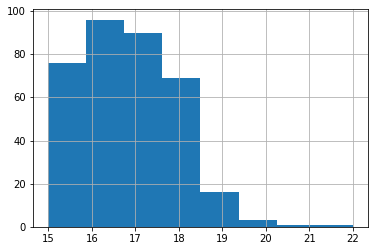

In [11]:
'''Проверка показателей параметра age(возраст учеников)'''
display('Количественные показатели:',stud_math.age.value_counts())
stud_math.age.hist(bins = 8)
stat_age = stud_math.age.describe()
display('Статистические показатели:', stat_age)

#### Предварительный анализ показывает, что данные заполнены полностью, гистограмма распределения нормальна с возможными выбросами в районе 21-22 лет.
### Проверяем данные на предмет выбросов:

In [12]:
print('25-й перцентиль: {},'.format(stat_age[4]), '75-й перцентиль: {},'.format(stat_age[6]), 
      "IQR: {}, ".format(stat_age[6]-stat_age[4]),"Границы выбросов: [{}, {}].".format(stat_age[4] - 
                                                                        1.5*(stat_age[6]-stat_age[4]), 
                                                                        stat_age[6] + 1.5*(stat_age[6]-stat_age[4])))

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


#### Таким образом, все возрасты учеников, за исключением 22-х лет, попадают в допустимый диапазон. Однако, ученик в возрасте 22 года всего один, и мы не будем исключать его из анализа
### Вывод: данные в столбце age полные, без существенных выбросов, дополнительная обработка не требуется

Количество пропущенных значений: 2


'Количественные показатели:'

4.00    125
2.00     88
3.00     87
1.00     47
0.00      3
Name: m_edu, dtype: int64

'Статистические показатели:'

count   350.00
mean      2.81
std       1.09
min       0.00
25%       2.00
50%       3.00
75%       4.00
max       4.00
Name: m_edu, dtype: float64

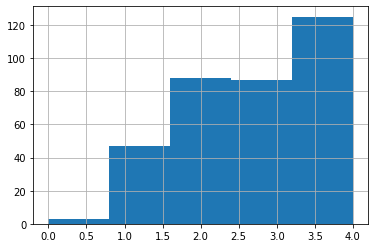

In [13]:
'''Проверка показателей параметра medu (образование матери)'''
print('Количество пропущенных значений:',stud_math.m_edu.isnull().sum())
display('Количественные показатели:',stud_math.m_edu.value_counts())
display('Статистические показатели:', stud_math.m_edu.describe())
stud_math.m_edu.hist(bins=5)

#### Похоже на линейную зависимость: количество пропорционально качеству образования
### Первичный анализ показывает, что матерей, имеющих высшее образование, большее количество, при этом матерей, имеющих начальное и среднее образование, примерно поровну. Без образования практически нет. 
### Данные в столбце medu практически полные, без существенных выбросов. Пропущенных значений 2, для удобства приравняем их нулю:

In [14]:
stud_math.m_edu.fillna(float(0), inplace=True)

Количество пропущенных значений: 21


'Количественные показатели:'

2.00     94
3.00     89
4.00     80
1.00     65
0.00      2
40.00     1
Name: f_edu, dtype: int64

'Статистические показатели:'

count   331.00
mean      2.66
std       2.32
min       0.00
25%       2.00
50%       3.00
75%       3.00
max      40.00
Name: f_edu, dtype: float64

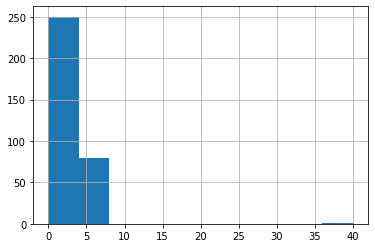

In [15]:
'''Проверка показателей параметра fedu (образование отца)'''
print('Количество пропущенных значений:', stud_math.f_edu.isnull().sum())
display('Количественные показатели:', stud_math.f_edu.value_counts()) 
display('Статистические показатели:', stud_math.f_edu.describe())
stud_math.f_edu.hist()

### Выводы: 
#### - отцов, имеющих высшее, среднее и неполное среднее образования, примерно одинаковое количество. Без образования практически нет
#### - пропущенных значений 21, заполнить их не представляется возможным ввиду большого количества и отсутствия информации
#### - имеется один выброс, равный 40. Вероятно, это ошибка при заведении данных, скорее всего, хотели завести 4
### Исправляем:

In [16]:
stud_math.f_edu[stud_math.f_edu == 40] = 4

'Количественные показатели:'

2.00    94
3.00    89
4.00    81
1.00    65
0.00     2
Name: f_edu, dtype: int64

count   331.00
mean      2.55
std       1.08
min       0.00
25%       2.00
50%       3.00
75%       3.00
max       4.00
Name: f_edu, dtype: float64

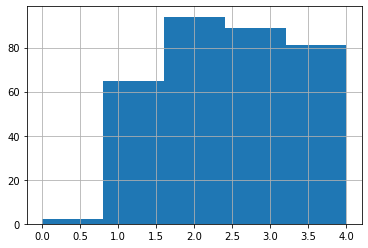

In [17]:
'''Проверяем...'''
display('Количественные показатели:', stud_math.f_edu.value_counts()) 
stud_math.f_edu.hist(bins=5)
stud_math.f_edu.describe()

#### Гистограмма похожа на нормальное распределение с небольшим смещением влево
#  

Количество пропущенных значений: 23


'Количественные показатели:'

1.00    219
2.00     86
3.00     17
4.00      7
Name: travel_time, dtype: int64

'Статистические показатели:'

count   329.00
mean      1.43
std       0.69
min       1.00
25%       1.00
50%       1.00
75%       2.00
max       4.00
Name: travel_time, dtype: float64

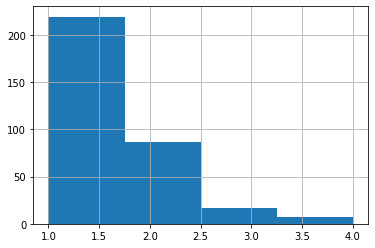

In [18]:
'''Проверка показателей параметра traveltime (время на дорогу)'''
print('Количество пропущенных значений:',stud_math.travel_time.isnull().sum())
display('Количественные показатели:', stud_math.travel_time.value_counts())
display('Статистические показатели:', stud_math.travel_time.describe())
stud_math.travel_time.hist(bins=4)

#### Похоже на экспоненту: функция количества учеников обратно пропорциональна квадрату (или кубу) времени на дорогу
### Выводы: 
#### - почти 60% учеников живут в непосредственной близости от школы, и только 7% учеников тратят на дорогу более 30 минут. Очевидно, что близость школы от дома - один из главных критериев при выборе школы
#### - пропущенных значений 23, заполнить их не представляется возможным ввиду большого количества и отсутствия информации
#### - выбросы отсутствуют, данные дополнительной обработки не требуют
##  

Количество пропущенных значений: 7


'Количественные показатели:'

2.00    173
1.00     90
3.00     58
4.00     24
Name: study_time, dtype: int64

'Статистические показатели:'

count   345.00
mean      2.05
std       0.84
min       1.00
25%       1.00
50%       2.00
75%       2.00
max       4.00
Name: study_time, dtype: float64

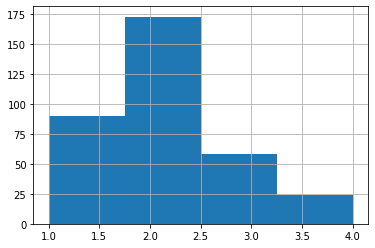

In [19]:
'''Проверка показателей параметра studytime (время на учёбу помимо школы)'''
print('Количество пропущенных значений:',stud_math.study_time.isnull().sum())
display('Количественные показатели:', stud_math.study_time.value_counts())
display('Статистические показатели:', stud_math.study_time.describe())
stud_math.study_time.hist(bins=4)

### Выводы: 
#### - данные достаточно полные (пропущенных значений всего 7), выбросы отсутствуют, дополнительной обработки данных не требуется
#### - 50% учеников тратят на учебу помимо школы 2-5 часов, при этом немало и учеников (порядка 25%), которые на учёбу тратят менее 2 часов
##  

Количество пропущенных значений: 7


'Количественные показатели:'

-6.00     173
-3.00      90
-9.00      58
-12.00     24
Name: std_time_gnr, dtype: int64

'Статистические показатели:'

count   345.00
mean     -6.14
std       2.52
min     -12.00
25%      -6.00
50%      -6.00
75%      -3.00
max      -3.00
Name: std_time_gnr, dtype: float64

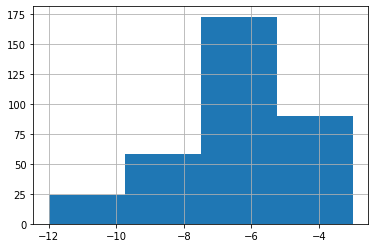

In [20]:
'''Проверка параметров показателя studytime,granular'''
print('Количество пропущенных значений:',stud_math.std_time_gnr.isnull().sum())
display('Количественные показатели:', stud_math.std_time_gnr.value_counts())
display('Статистические показатели:', stud_math.std_time_gnr.describe())
stud_math.std_time_gnr.hist(bins=4)

### Выводы: 
#### данные достаточно полные (пропущенных значений всего 7), выбросы отсутствуют, дополнительной обработки данных не требуется
#### гистограмма распределения и количественные характеристики очень похожи на данные параметра studytime (проведем их анализ чуть позже)
##  

Количество пропущенных значений: 20


'Количественные показатели:'

0.00    273
1.00     38
2.00     11
3.00     10
Name: failures, dtype: int64

'Статистические показатели:'

count   332.00
mean      0.27
std       0.67
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       3.00
Name: failures, dtype: float64

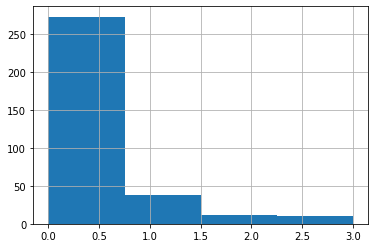

In [21]:
'''Проверка параметра failures (внеучебные неудачи)'''
print('Количество пропущенных значений:',stud_math.failures.isnull().sum())
display('Количественные показатели:', stud_math.failures.value_counts())
display('Статистические показатели:', stud_math.failures.describe())
stud_math.failures.hist(bins=4)

#### Похоже на экспоненту: количество учеников, имеющих внеучебные неудачи, обратно пропорционально квадрату (или кубу) количества самих внеучебных неудач
### Незаполненных позиций 20, заполнить их не представляется возможным ввиду отсутствия информации
### Выбросы отсутствуют, данные дополнительной обработки не требуют
##  

Количество пропущенных значений: 24


'Количественные показатели:'

4.00     163
5.00      88
3.00      56
2.00      14
1.00       6
-1.00      1
Name: fam_rel, dtype: int64

'Статистические показатели:'

count   328.00
mean      3.94
std       0.92
min      -1.00
25%       4.00
50%       4.00
75%       5.00
max       5.00
Name: fam_rel, dtype: float64

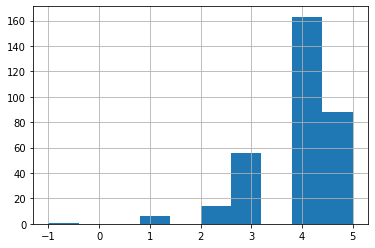

In [22]:
'''Проверка параметра famrel (семейные отношения)'''
print('Количество пропущенных значений:',stud_math.fam_rel.isnull().sum())
display('Количественные показатели:', stud_math.fam_rel.value_counts())
display('Статистические показатели:', stud_math.fam_rel.describe())
stud_math.fam_rel.hist()

### Выводы: 
### - ученики в-основном из благополучных семей, количество учеников из семей с отношеними "ниже среднего" составляет всего 6%
### - количество пропущенных значений 24, заполнить их не представляется возможным ввиду отсутствия информации. 
### - имеется один очевидный выброс, который находится за пределами допустимых значений (от 1 до 5)
## Делаем его NaN:

In [23]:
stud_math.loc[stud_math.fam_rel == -1] = np.nan

'Статистические показатели:'

count   327.00
mean      3.96
std       0.88
min       1.00
25%       4.00
50%       4.00
75%       5.00
max       5.00
Name: fam_rel, dtype: float64

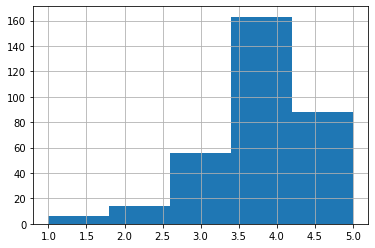

In [24]:
'''Проверяем:...'''
stud_math.fam_rel.hist(bins=5)
display('Статистические показатели:', stud_math.fam_rel.describe())

#### Таким образом, получили смещенный слегка влево нормальный закон распределения
##  

Количество пропущенных значений: 9


'Количественные показатели:'

3.00    132
4.00    102
2.00     58
5.00     35
1.00     16
Name: free_time, dtype: int64

'Статистические показатели:'

count   343.00
mean      3.24
std       1.00
min       1.00
25%       3.00
50%       3.00
75%       4.00
max       5.00
Name: free_time, dtype: float64

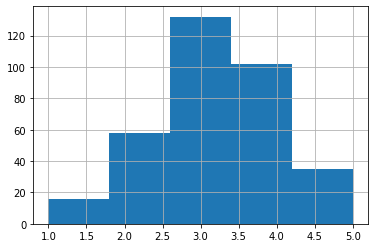

In [25]:
'''Проверка параметра "Свободное время после школы", freetime '''
print('Количество пропущенных значений:',stud_math.free_time.isnull().sum())
display('Количественные показатели:', stud_math.free_time.value_counts())
display('Статистические показатели:', stud_math.free_time.describe())
stud_math.free_time.hist(bins=5)

### Выводы: 
### - данные в столбце достаточно чистые, выбросов нет, количество пропущенных значений всего 9
### - нормальное распределение данных с небольшим смещением "вправо"
### - дополнительной обработки данных не требуется
##  

Количество пропущенных значений: 7


'Количественные показатели:'

3.00    118
2.00     91
4.00     74
5.00     43
1.00     19
Name: go_out, dtype: int64

'Статистические показатели:'

count   345.00
mean      3.09
std       1.09
min       1.00
25%       2.00
50%       3.00
75%       4.00
max       5.00
Name: go_out, dtype: float64

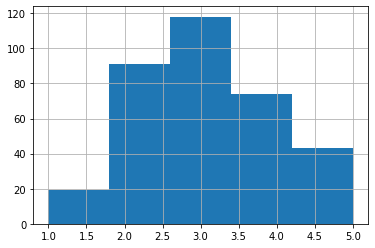

In [26]:
'''Проверка параметра goout (проведение времени с друзьями)'''
print('Количество пропущенных значений:',stud_math.go_out.isnull().sum())
display('Количественные показатели:', stud_math.go_out.value_counts())
display('Статистические показатели:', stud_math.go_out.describe())
stud_math.go_out.hist(bins=5)

### Выводы: 
#### - данные в столбце достаточно чистые, выбросов нет, количество пропущенных значений всего 7
#### - нормальное распределение с небольшим смещением "вправо"
#### - дополнительной обработки данных не требуется
##  

Количество пропущенных значений: 14


'Количественные показатели:'

5.00    123
3.00     81
4.00     53
1.00     45
2.00     36
Name: health, dtype: int64

'Статистические показатели:'

count   338.00
mean      3.51
std       1.41
min       1.00
25%       3.00
50%       4.00
75%       5.00
max       5.00
Name: health, dtype: float64

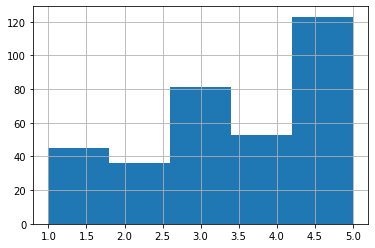

In [27]:
'''Проверка параметра health (здоровье)'''
print('Количество пропущенных значений:',stud_math.health.isnull().sum())
display('Количественные показатели:', stud_math.health.value_counts())
display('Статистические показатели:', stud_math.health.describe())
stud_math.health.hist(bins=5)

### Выводы: 
#### - гистограмма похожа на линейный закон распределения данных
#### - данные в столбце достаточно чистые, выбросов нет, количество пропущенных значений всего 14
#### - достаточно много учеников (около 25%) с состоянием здоровья "ниже среднего"
#### - дополнительной обработки данных не требуется
##  

Количество пропущенных значений: 11


'Количественные показатели:'

0.00      74
2.00      60
4.00      52
6.00      30
8.00      20
10.00     17
12.00     12
14.00     11
3.00       7
16.00      7
7.00       6
18.00      5
5.00       5
20.00      4
22.00      3
9.00       3
1.00       3
15.00      2
13.00      2
11.00      2
25.00      1
54.00      1
385.00     1
26.00      1
56.00      1
24.00      1
212.00     1
21.00      1
75.00      1
30.00      1
19.00      1
38.00      1
40.00      1
23.00      1
17.00      1
28.00      1
Name: absences, dtype: int64

'Статистические показатели:'

count   341.00
mean      8.07
std      24.74
min       0.00
25%       2.00
50%       4.00
75%       8.00
max     385.00
Name: absences, dtype: float64

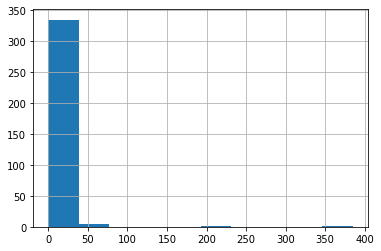

In [28]:
'''Проверка параметра absences (количество пропущенных занятий)'''
print('Количество пропущенных значений:',stud_math.absences.isnull().sum())
display('Количественные показатели:', stud_math.absences.value_counts())
stat_abss = stud_math.absences.describe()
display('Статистические показатели:', stat_abss)
stud_math.absences.hist()

### Предварительный анализ: данные достаточно полные, пропущенных значений всего 7, имеются выбросы
### Рассчитаем границы выбросов и осуществим фильтрацию значений:

In [29]:
print('25-й перцентиль: {},'.format(stat_abss[4]), '75-й перцентиль: {},'.format(stat_abss[6]), 
      "IQR: {}, ".format(stat_abss[6]-stat_abss[4]),"Границы выбросов: [{}, {}].".format(stat_abss[4] - 
                                                                            1.5*(stat_abss[6]-stat_abss[4]), 
                                                                            stat_abss[6] + 1.5*(stat_abss[6]-stat_abss[4])))

25-й перцентиль: 2.0, 75-й перцентиль: 8.0, IQR: 6.0,  Границы выбросов: [-7.0, 17.0].


### Вывод: все значения параметра укладываются в нижнюю границу выбросов, за пределами верхней границы находится 27 записей (порядка 8% значений)
### Исключаем их из обработки:

Исключенных из обработки записей: 27


'Количественные показатели:'

0.00     74
2.00     60
4.00     52
6.00     30
8.00     20
10.00    17
12.00    12
14.00    11
16.00     7
3.00      7
7.00      6
5.00      5
1.00      3
9.00      3
11.00     2
13.00     2
15.00     2
17.00     1
Name: absences, dtype: int64

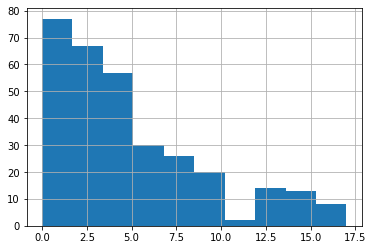

In [30]:
print('Исключенных из обработки записей:', stud_math.absences[stud_math.absences > 17].count())
stud_math = stud_math.loc[stud_math.absences < 18]
stud_math.absences.hist()
display('Количественные показатели:', stud_math.absences.value_counts())

#### Таким образом, у нас получилась гистограмма с линейным (или квадратичным) обратным распределением. При этом для дальнейшего анализа у нас остались в-основном записи, повторяющиеся не менее одного раза (число прогулов два и более)
##  

### Проведём корреляционный анализ столбцов с числовыми данными:

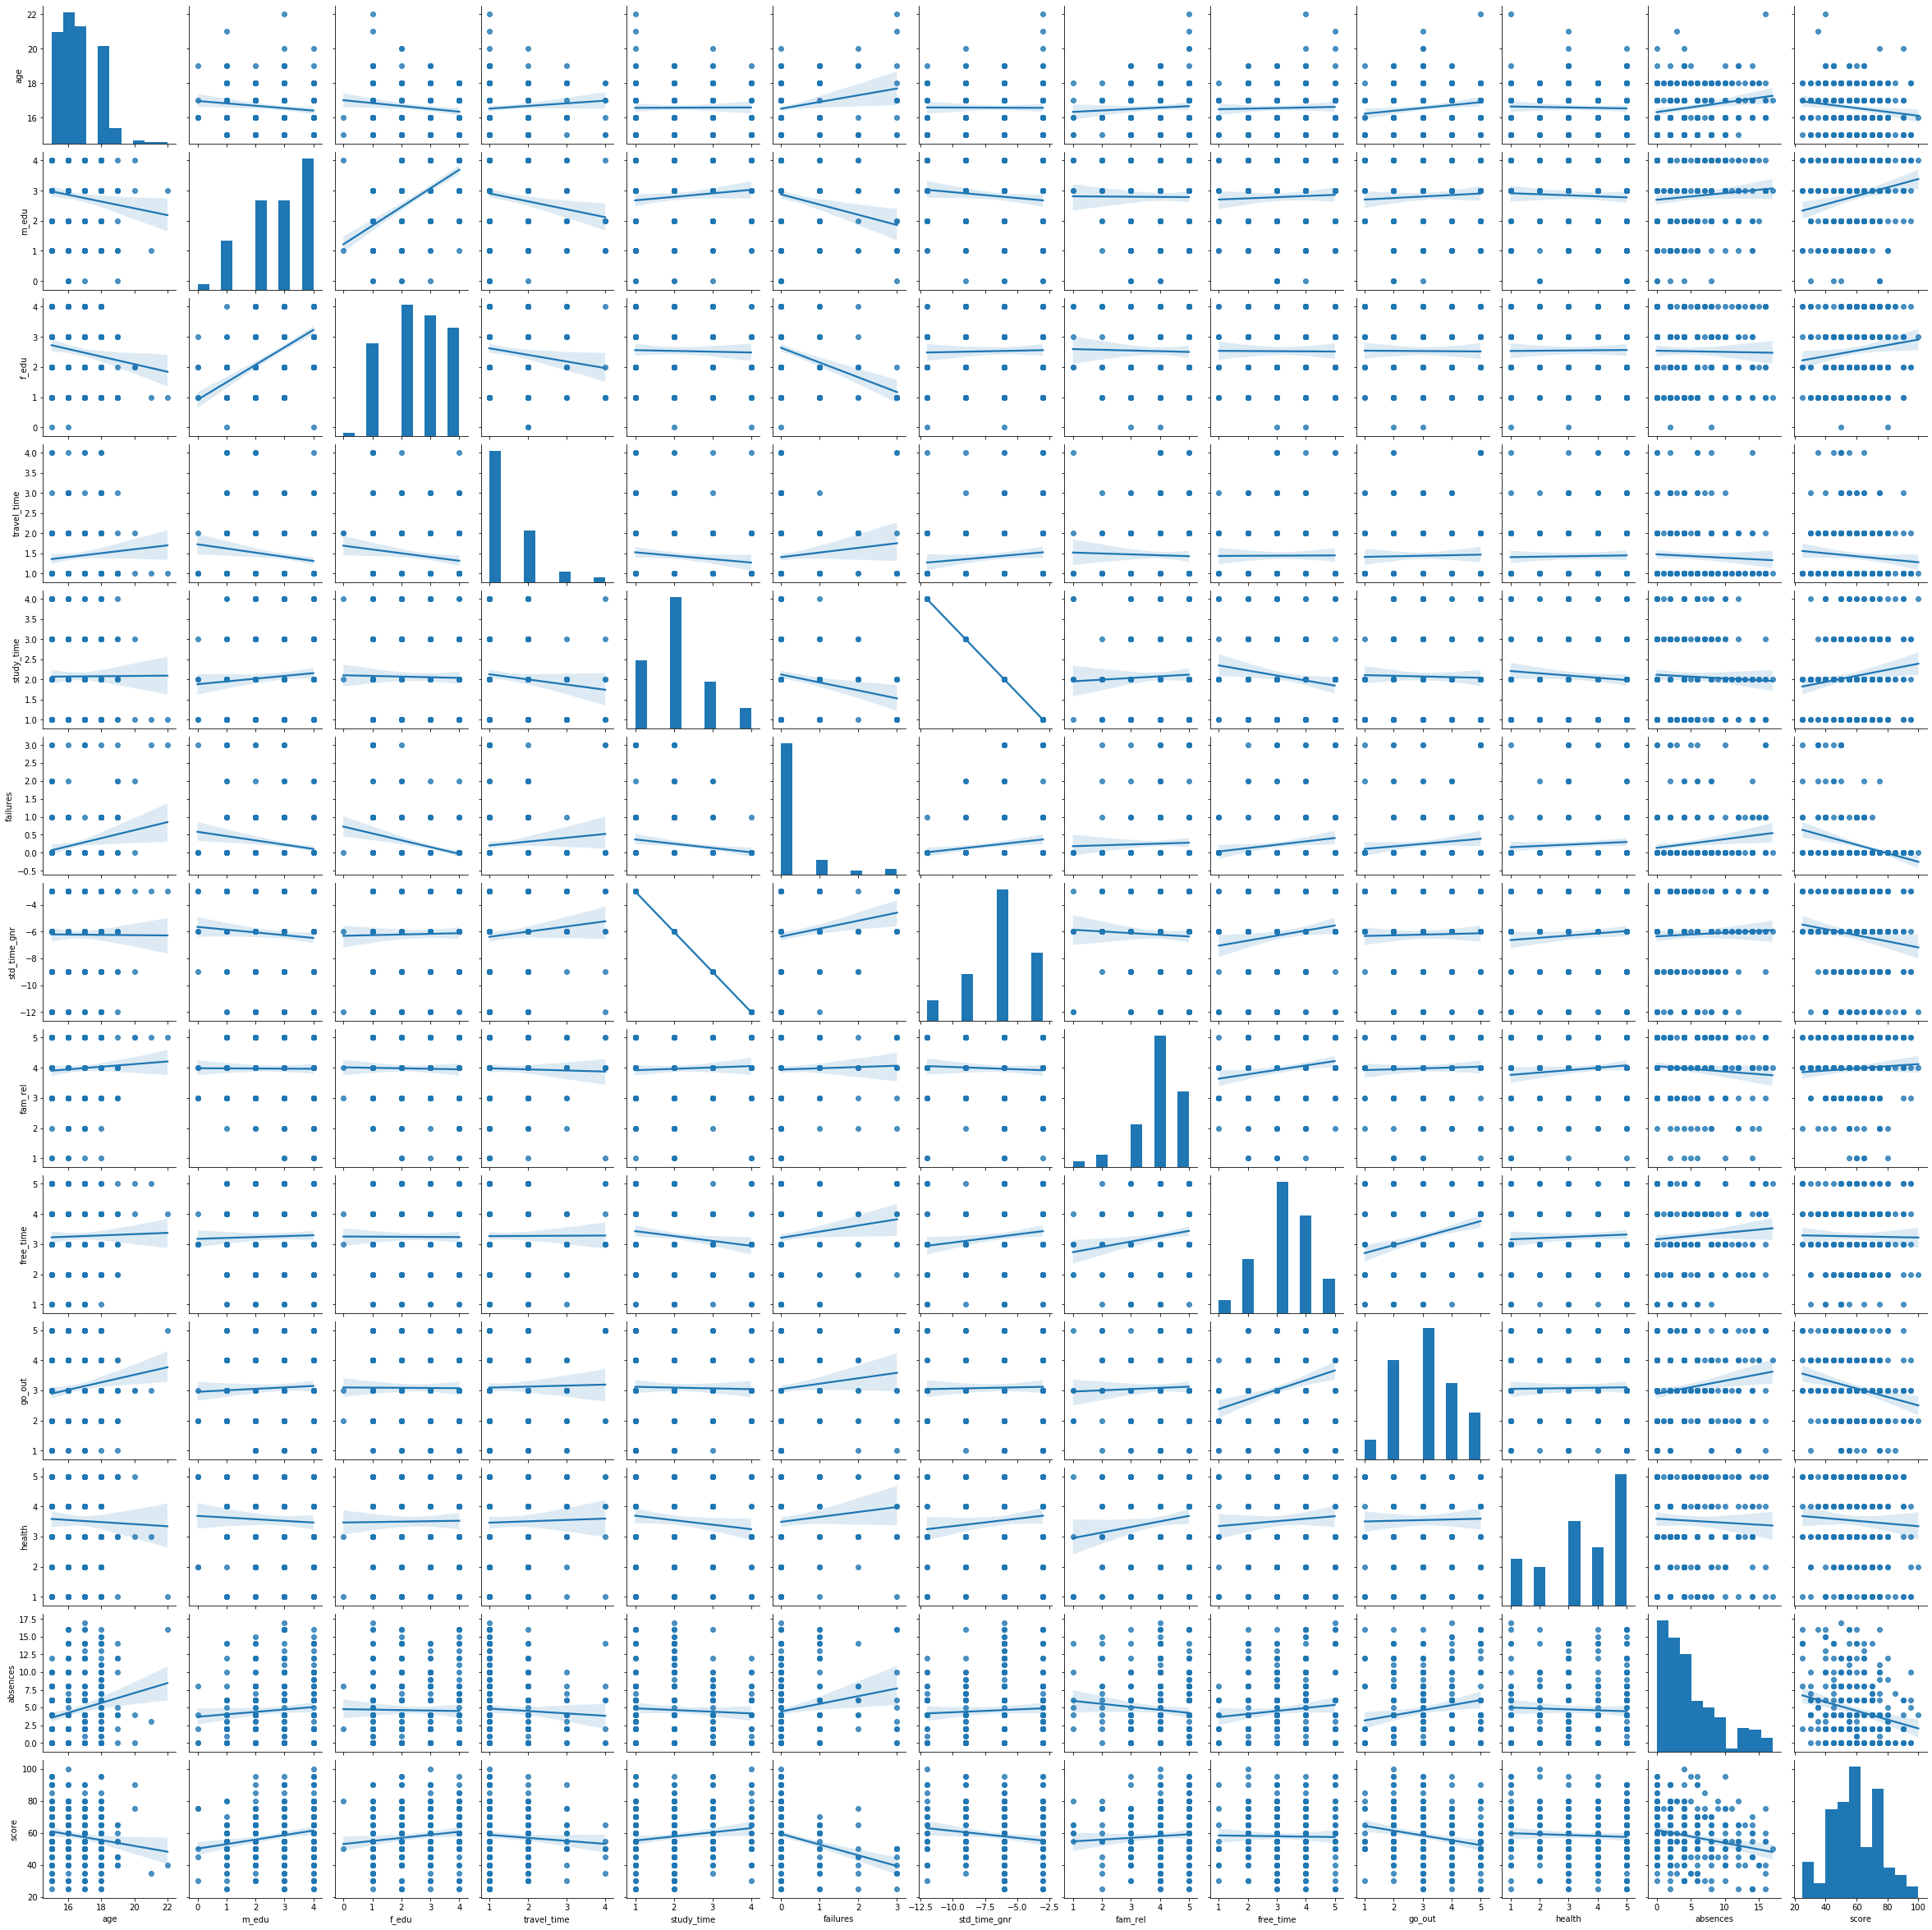

In [31]:
sns.pairplot(stud_math, kind = 'reg')

In [32]:
stud_math.corr()

,age,m_edu,f_edu,travel_time,study_time,failures,std_time_gnr,fam_rel,free_time,go_out,health,absences,score
age,1.00,-0.13,-0.15,0.09,0.01,0.21,-0.01,0.06,0.03,0.14,-0.03,0.20,-0.14
m_edu,-0.13,1.00,0.60,-0.17,0.09,-0.20,-0.09,-0.01,0.03,0.05,-0.04,0.09,0.20
f_edu,-0.15,0.60,1.00,-0.14,-0.02,-0.31,0.02,-0.02,-0.01,-0.01,0.01,-0.02,0.13
travel_time,0.09,-0.17,-0.14,1.00,-0.10,0.11,0.10,-0.03,0.00,0.02,0.02,-0.05,-0.08
study_time,0.01,0.09,-0.02,-0.10,1.00,-0.15,-1.00,0.04,-0.14,-0.02,-0.09,-0.05,0.14
failures,0.21,-0.20,-0.31,0.11,-0.15,1.00,0.15,0.03,0.14,0.11,0.08,0.16,-0.28
std_time_gnr,-0.01,-0.09,0.02,0.10,-1.00,0.15,1.00,-0.04,0.14,0.02,0.09,0.05,-0.14
fam_rel,0.06,-0.01,-0.02,-0.03,0.04,0.03,-0.04,1.00,0.16,0.03,0.12,-0.09,0.06
free_time,0.03,0.03,-0.01,0.00,-0.14,0.14,0.14,0.16,1.00,0.29,0.06,0.10,-0.02
go_out,0.14,0.05,-0.01,0.02,-0.02,0.11,0.02,0.03,0.29,1.00,0.02,0.18,-0.20


### Какие основные выводы можно сделать из полученной корреляционной матрицы?
#### 1. Наблюдается полная обратная корреляционная зависимость между двумя параметрами: studytime и studytime,granular: количественные показатели у обоих абсолютно одинаковые, включая количество пропущенных значений, отличаются только соответствующие качественные показатели. В параметре study_time они равны 1, 2, 3, 4, в параметре же study_time,granular -3, -6, -9, -12 соответственно, т.е. study_time,granular равен study_time, умноженному на минус 3. По сути параметры studytime и studytime,granular являются одинаковыми, только имеют различные обозначения.Один из этих параметров мы можем исключить из дальнейшего анализа, им будет studytime,granular.
#### 2. На итоговую оценку по математике (score) наибольшее влияние оказывает 7 числовых параметров:
#### - возраст ученика (age): чем меньше возраст, тем легче даётся наука;
#### - образование родителей (m_edu, f_edu): чем образованнее родители, тем лучше успеваемость учеников. Очевидно, что родители с высшим образованием могут обеспечить гораздо лучшую интеллектуальную поддержку и помощь своему ребёнку;
#### - время, которое дополнительно тратит ученик на обучение (study_time): чем больше это время, тем лучше успехи (логично, не правда ли?)
#### - внеучебные неудачи (failures	) (внимание: наибольшее вляние!!!): чем больше неудач, чем хуже успеваемость (до учёбы ли, если другие проблемы не дают сосредоточиться на учёбе!)
#### - проведение времени с друзьями (go_out): друзья постоянно отвлекают от учёбы (особенно двоечники), то погулять сходить, то музыку послушать, то на тусовку срочно надо, то пивка попить и прочее, прочее, прочее... Когда тут учиться?
#### - количество пропущенных занятий (absences): чем меньше пропущенных занятий, тем лучше результат. Странно, не правда ли ? :)
#### 3. Ряд параметров на оценку по госэкзамену по математике практически не влияет. Это: время в пути до школы (travel_time), семейные отношения (fam_rel), свободное время после школы (free_time) и состояние здоровья (health). Эти данные я бы исключил из дальнейшего анализа, как несущественные.
### Проанализируем дополнительно взаимосвязь между параметрами (столбцами):
#### 1. Возраст ученика: 
#### - сильная обратная корреляция с образованием родителей может говорить о том, что решение родителей о создании семьи и рождении детей  принималось в зависимости от окончания образования
#### - с возрастом у ученика всё больше всё больше возникает вероятность наделать глупостей (failures) (родителей мы уже не слушаемся, взрослые же !!!, пытаемся жить своим умом, а жизненного опыта не хватает)
#### - чем старше ученик, тем меньше ему хочется учиться и больше времени хочется проводить с друзьями, отсюда и прогулы занятий (absences), и жизненные неурядицы (failures), и, как результат, не очень хорошие итоговые оценки
#### 2. Образование родителей (medu и fedu): 
#### - наблюдается сильная корреляция между этими двумя параметрами. Данный момент можно объяснить тем, что супружеские пары подбираются, как правило, по общности вкусов, интересов, взглядов, в том числе и уровню образования
#### - обратная корреляционная зависимость между образованием родителей и временем ученика на дорогу до школы может объясняться тем, что более образованные родители имеют более высокооплачиваемую работу и, соответственно, более высокое благосотояние, что позволяет ученику использовать для перемещения между домом и школой личный автотранспорт (аемейные машины, такси), а не ходить пешком или пользоваться общественным транспортом
#### - прослеживавется устойчивая взаимосвязь между образованием родителей (medu и fedu) и вероятностью попадания ученика в неприятную ситуацию (failures). Образованные интеллектуальные родители сами не создадут и не вляпаются в неприятную ситуацию, и своего ребёнка оградят от неё. Примером и советом. 
#### 3. Время на дорогу (travel_time): прямая корреляционная связь с количеством внеучебных неудач (failures) может объясняться тем, что в дороге человека окружает множество людей, ученик оказывается в сосвершенно различных ситуациях, и вероятность попасть в какую-либо неприятную ситуацию сильно возрастает
#### 4. Время на учёбу помимо школы (study_time): дополнительное увеличение времени на учёбу совершенно логически уменьшает количество времени после школы (free_time), количество внеучебных неудач (failures) (становится просто некогда попадать в неприятную ситуацию
#### 5. Количество внеучебных неудач (failures): при наличии большого количества свободного времени (free_time) его всегда хочется провести как-то интересно, отсюда поиск приключений и, как результат, более высокая вероятность попадания в неприятную ситуацию. А с друзьями таких приключений ещё больше!!! Когда неприятности, какие могут быть уроки (absences)?
#### 6. При хороших семейных отношениях (fam_rel) хочется больше времени проводить в семейном кругу (free_time), а не искать приключения с друзьями (go_out). Спокойная доброжелательная семейная обстановка, отсутствие неприятностей (failures) вполне логично сказываются на общем состоянии здоровья (health).
#### 7. Видна сильная взаимосвязь между параметрами freetime и goout (свободным временем учеников и времени, проведенном с друзьями), что вполне логично. При этом, наличие свободного времени, в отличие от общения с друзьями, практически не оказывает влияния на успеваемость учащихся.


In [33]:
'''Исключаем параметр std_time_gnr (studytime,granular) из дальнейшего анализа'''
stud_math.drop(['std_time_gnr'], inplace = True, axis = 1)

## ЭТАП 2
## Анализ номинативных показателей

'Количественные показатели:'

GP    275
MS     39
Name: school, dtype: int64

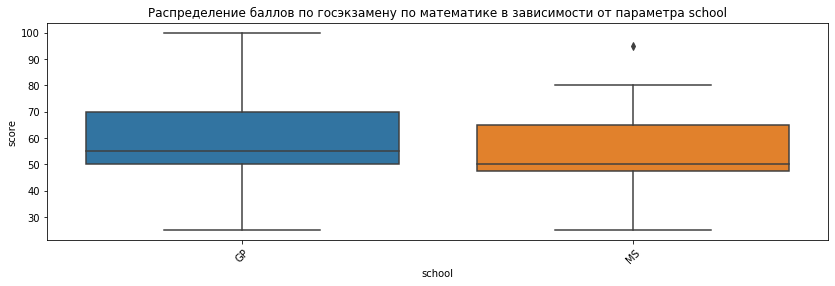

Статистически значимые различия для параметра school не найдены


In [34]:
'''Проверка параметра school (школа посещения)'''
display('Количественные показатели:', stud_math.school.value_counts())
data_boxplot('school')
data_stat_dif('school')
#display('Статистические показатели:', stud_math[stud_math.school == 'MS']['score'].describe())
#stud_math[stud_math.school == 'MS']['score'].value_counts()

### Выводы: 
#### 1. Подавляющее число учеников (почти 88%), участвующих в анализе, посещают одну школу.
#### 2. Данные полные, дополнительной обработки данных проводить не надо.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр school можно исключить из дальнейшего анализа (построения модели).

###  

'Количественные показатели:'

F    161
M    153
Name: sex, dtype: int64

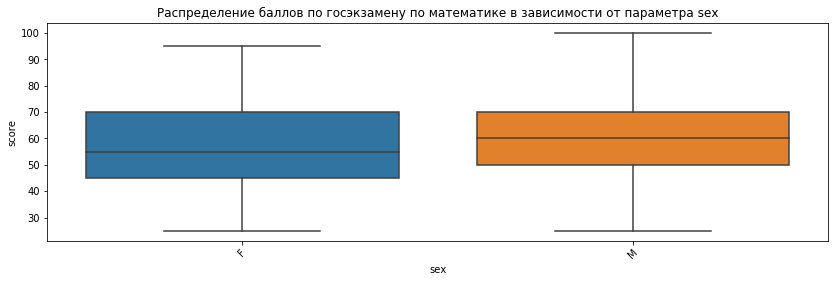

Найдены статистически значимые различия для параметра sex


In [35]:
'''Проверка параметра sex (пол учеников)'''
display('Количественные показатели:', stud_math.sex.value_counts())
data_boxplot('sex')
data_stat_dif('sex')

### Выводы: 
#### 1. Учеников женского и мужского пола примерно одинаковое количество.
#### 2. Данные полные, выбросы отсутствуют, дополнительной обработки данных проводить не надо.
### 3. Найдены статистически значимые различия данных для оценки влияния успеваемости, по этой причине параметр sex должен быть использован для дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 13


'Количественные показатели:'

U    235
R     66
Name: address, dtype: int64

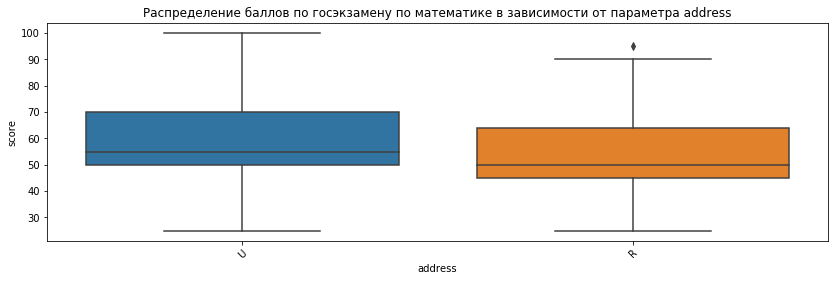

Найдены статистически значимые различия для параметра address


In [36]:
'''Проверка параметра address (место проживания учеников)'''
print('Количество пропущенных значений:',stud_math.address.isnull().sum())
display('Количественные показатели:', stud_math.address.value_counts())
data_boxplot('address')
data_stat_dif('address')

### Выводы: 
#### 1. Три четверти учеников (78%) живет в городе. 
#### 2. Данные достаточно полные, пропущенных значений 13, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
### 3. Найдены статистически значимые различия данных для оценки влияния успеваемости, по этой причине параметр address должен быть использован для дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 18


'Количественные показатели:'

GT3    207
LE3     89
Name: fam_size, dtype: int64

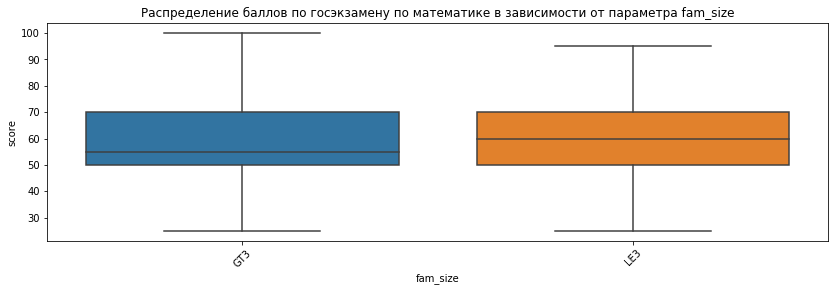

Статистически значимые различия для параметра fam_size не найдены


In [37]:
'''Проверка параметра famsize (размер семьи)'''
print('Количество пропущенных значений:',stud_math.fam_size.isnull().sum())
display('Количественные показатели:', stud_math.fam_size.value_counts())
data_boxplot('fam_size')
data_stat_dif('fam_size')

### Выводы: 
#### 1. Число семей с количеством членов больше трех больше почти в 2,5 раза.
#### 2. Данные достаточно полные, пропущенных значений 18, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр fam_size можно исключить из дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 32


'Количественные показатели:'

T    254
A     28
Name: p_status, dtype: int64

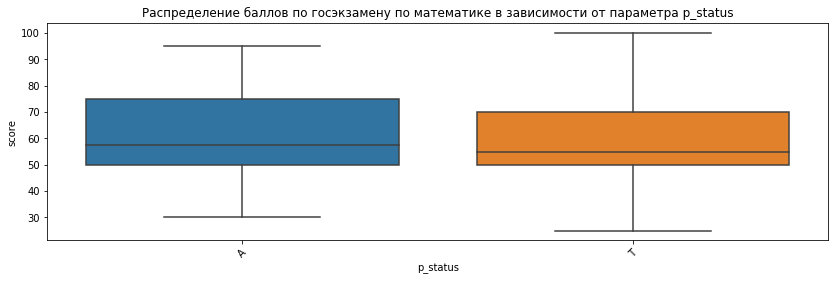

Статистически значимые различия для параметра p_status не найдены


In [38]:
'''Проверка параметра pstatus (статус совместного проживания родителей)'''
print('Количество пропущенных значений:',stud_math.p_status.isnull().sum())
display('Количественные показатели:', stud_math.p_status.value_counts())
data_boxplot('p_status')
data_stat_dif('p_status')

### Выводы: 
#### 1. Практически все семьи полные (почти 90%).
#### 2. Пропущенных значений 32, заполнить их не представляется возможным ввиду большого количества и отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр p_status можно исключить из дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 14


'Количественные показатели:'

other       102
services     79
teacher      46
at_home      44
health       29
Name: m_job, dtype: int64

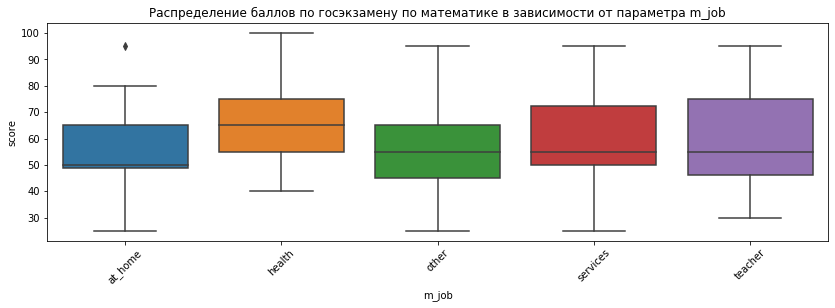

Найдены статистически значимые различия для параметра m_job


In [39]:
'''Проверка параметра m_job (работа матери)'''
print('Количество пропущенных значений:',stud_math.m_job.isnull().sum())
display('Количественные показатели:', stud_math.m_job.value_counts())
data_boxplot('m_job')
data_stat_dif('m_job')

### Выводы: 
#### 1. Работа матерей распределена достаточно равномерно, немного больше работает в сфере услуг.
#### 2. Пропущенных значений 14, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
### 3. Найдены статистически значимые различия данных для оценки влияния успеваемости, по этой причине параметр m_job должен быть использован для дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 28


'Количественные показатели:'

other       159
services     78
teacher      22
at_home      14
health       13
Name: f_job, dtype: int64

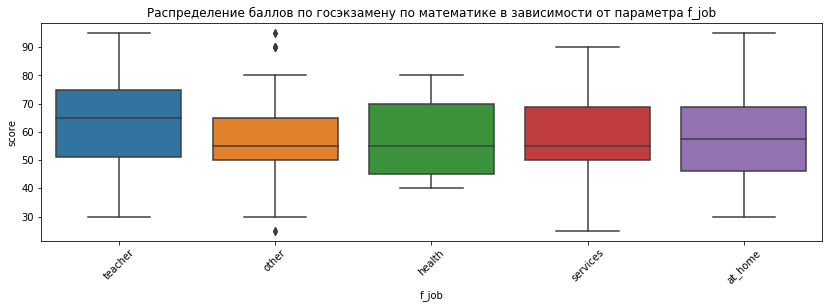

Статистически значимые различия для параметра f_job не найдены


In [40]:
'''Проверка параметра f_job (работа отца)'''
print('Количество пропущенных значений:',stud_math.f_job.isnull().sum())
display('Количественные показатели:', stud_math.f_job.value_counts())
data_boxplot('f_job')
data_stat_dif('f_job')

### Выводы: 
#### 1. Основное количество отцов работает в сфере услуг и по другим специальностям (83%).
#### 2. Пропущенных значений 28, заполнить их не представляется возможным ввиду большого количества и отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр f_job можно исключить из дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 15


'Количественные показатели:'

course        110
reputation     84
home           75
other          30
Name: reason, dtype: int64

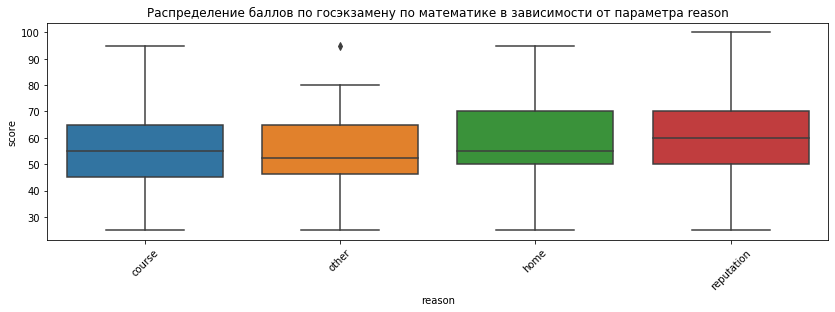

Статистически значимые различия для параметра reason не найдены


In [41]:
'''Проверка параметра reason (причина выбора школы)'''
print('Количество пропущенных значений:',stud_math.reason.isnull().sum())
display('Количественные показатели:', stud_math.reason.value_counts())
data_boxplot('reason')
data_stat_dif('reason')

### Выводы: 
#### 1. Основные причины выбора школы распределны примерно равномерно, однако образовательная программа является приоритетной (наверное, по этой причине школа "GP" пользуется бОльшей популярностью).
#### 2. Пропущенных значений 15, заполнить их не представляется возможным ввиду  отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр reason можно исключить из дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 28


'Количественные показатели:'

mother    198
father     74
other      14
Name: guardian, dtype: int64

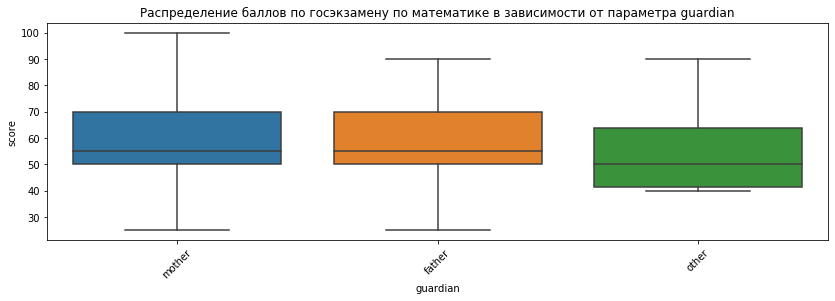

Статистически значимые различия для параметра guardian не найдены


In [42]:
'''Проверка параметра guardian (опекунство)'''
print('Количество пропущенных значений:',stud_math.guardian.isnull().sum())
display('Количественные показатели:', stud_math.guardian.value_counts())
data_boxplot('guardian')
data_stat_dif('guardian')

### Выводы: 
#### 1. В подавляющем числе семей (почти 70%) основную помощь учащемуся оказывают матери, и только в 26% - отцы.
#### 2. Пропущенных значений 28, заполнить их не представляется возможным ввиду большого количества и отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр guardian можно исключить из дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 9


'Количественные показатели:'

no     262
yes     43
Name: school_sup, dtype: int64

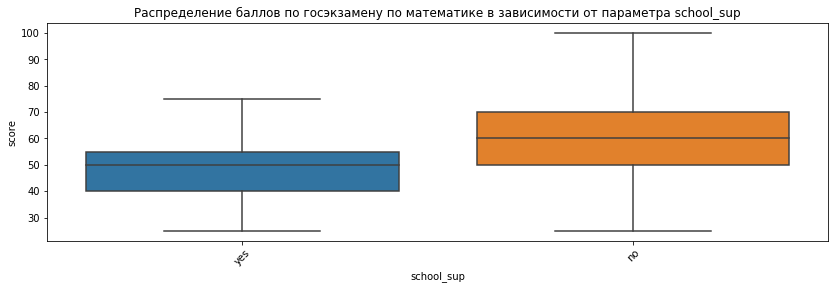

Найдены статистически значимые различия для параметра school_sup


In [43]:
'''Проверка параметра school_sup (дополнительная образовательная поддержка)'''
print('Количество пропущенных значений:',stud_math.school_sup.isnull().sum())
display('Количественные показатели:', stud_math.school_sup.value_counts())
data_boxplot('school_sup')
data_stat_dif('school_sup')

### Выводы: 
#### 1. Основное количество учеников (86%) учатся без дополнительной образовательной поддержки со стороны школы.
#### 2. Данные достаточно полные, пропущенных значений всего 9, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
### 3. Найдены статистически значимые различия данных для оценки влияния успеваемости, по этой причине параметр school_sup должен быть использован для дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 30


'Количественные показатели:'

yes    174
no     110
Name: fam_sup, dtype: int64

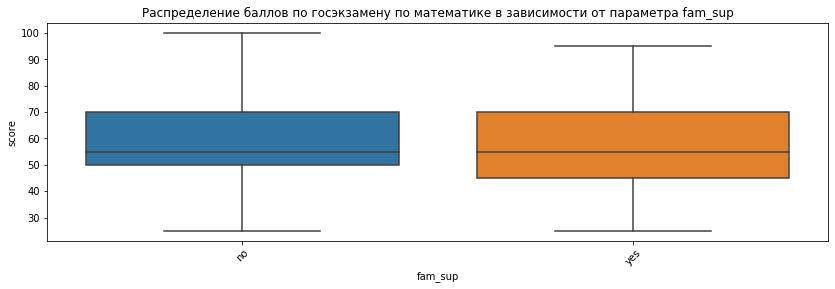

Статистически значимые различия для параметра fam_sup не найдены


In [44]:
'''Проверка параметра fam_sup (семейная образовательная поддержка)'''
print('Количество пропущенных значений:',stud_math.fam_sup.isnull().sum())
display('Количественные показатели:', stud_math.fam_sup.value_counts())
data_boxplot('fam_sup')
data_stat_dif('fam_sup')

### Выводы: 
#### 1. Более половины учеников обращаются за помощью в учебе к семье.
#### 2. Пропущенных значений 30, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр fam_sup можно исключить из дальнейшего анализа (построения модели).
###  

Количество пропущенных значений: 33


'Количественные показатели:'

no     152
yes    129
Name: paid, dtype: int64

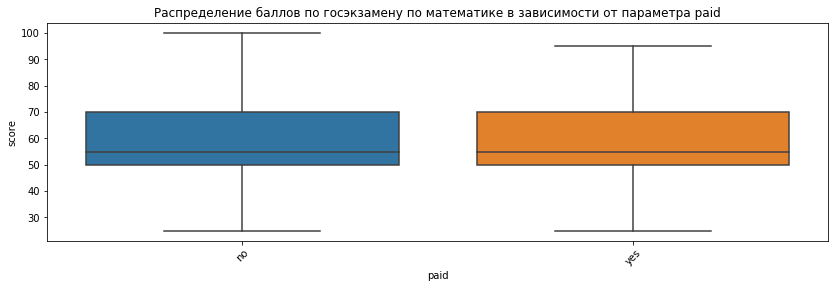

Статистически значимые различия для параметра paid не найдены


In [45]:
'''Проверка параметра paid (дополнительные платные занятия по математике)'''
print('Количество пропущенных значений:',stud_math.paid.isnull().sum())
display('Количественные показатели:', stud_math.paid.value_counts())
data_boxplot('paid')
data_stat_dif('paid')

### Выводы: 
#### 1. Чуть более половины учеников не пользуются дополнительными платными уроками по математике, справляются сами.
#### 2. Пропущенных значений 33, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр paid можно исключить из дальнейшего анализа (построения модели)
###  

Количество пропущенных значений: 12


'Количественные показатели:'

yes    158
no     144
Name: activities, dtype: int64

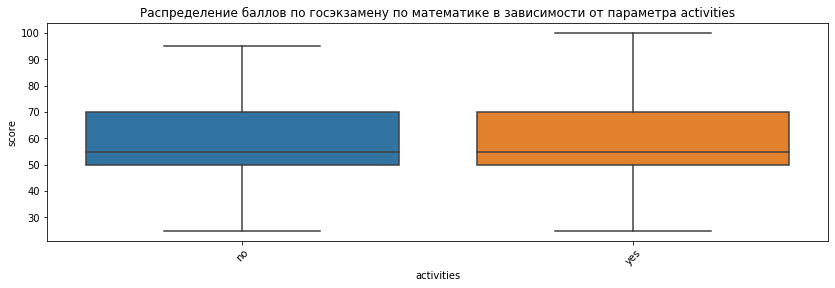

Статистически значимые различия для параметра activities не найдены


In [46]:
'''Проверка параметра activities (дополнительные внеучебные занятия)'''
print('Количество пропущенных значений:',stud_math.activities.isnull().sum())
display('Количественные показатели:', stud_math.activities.value_counts())
data_boxplot('activities')
data_stat_dif('activities')

### Выводы: 
#### 1. Дополнительные  учебные занятия посещает чуть больше половины учеников.
#### 2. Данные достаточно полные, пропущенных значений всего 12, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр activities можно исключить из дальнейшего анализа (построения модели)
###  

Количество пропущенных значений: 12


'Количественные показатели:'

yes    242
no      60
Name: nursery, dtype: int64

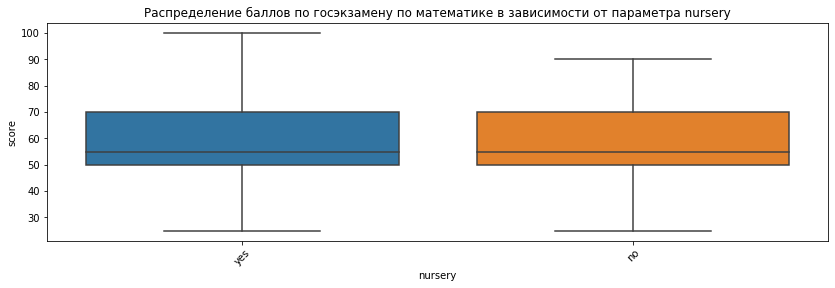

Статистически значимые различия для параметра nursery не найдены


In [47]:
'''Проверка параметра nursery (посещал детский сад)'''
print('Количество пропущенных значений:',stud_math.nursery.isnull().sum())
display('Количественные показатели:', stud_math.nursery.value_counts())
data_boxplot('nursery')
data_stat_dif('nursery')

### Выводы: 
#### 1. 80% учеников посещали перед школой детский сад.
#### 2. Данные достаточно полные, пропущенных значений всего 12, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр nursery можно исключить из дальнейшего анализа (построения модели)
###  

Количество пропущенных значений: 16


'Количественные показатели:'

yes    288
no      10
Name: higher, dtype: int64

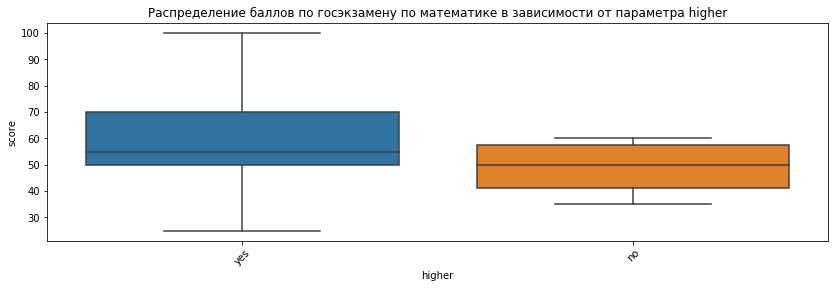

Статистически значимые различия для параметра higher не найдены


In [48]:
'''Проверка параметра higher (хочет получить высшее образование)'''
print('Количество пропущенных значений:',stud_math.higher.isnull().sum())
display('Количественные показатели:', stud_math.higher.value_counts())
data_boxplot('higher')
data_stat_dif('higher')

### Выводы: 
#### 1. Подавляющее число учеников (96%) хотят получить высшее образование.
#### 2. Данные достаточно полные, пропущенных значений всего 16, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр higher можно исключить из дальнейшего анализа (построения модели)
###  

Количество пропущенных значений: 26


'Количественные показатели:'

yes    241
no      47
Name: internet, dtype: int64

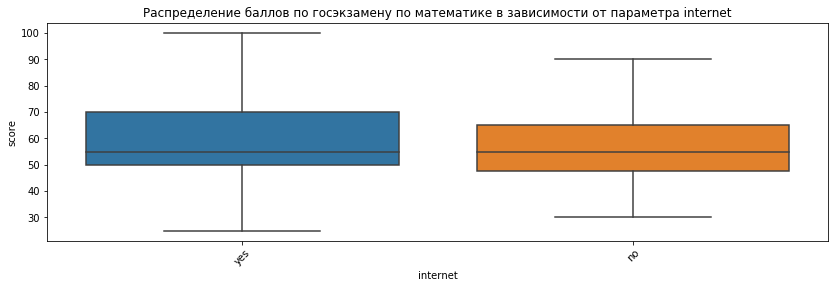

Статистически значимые различия для параметра internet не найдены


In [49]:
'''Проверка параметра internet (наличие интернета дома)'''
print('Количество пропущенных значений:',stud_math.internet.isnull().sum())
display('Количественные показатели:', stud_math.internet.value_counts())
data_boxplot('internet')
data_stat_dif('internet')

### Выводы: 
#### 1. У большинства учеников (84%) установлен дома интернет (наверное, данный датасет старый, тогда интернет был ещё не у всех)
#### 2. Данные достаточно полные, пропущенных значений 26, заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр internet можно исключить из дальнейшего анализа (построения модели)
###  

Количество пропущенных значений: 28


'Количественные показатели:'

no     197
yes     89
Name: romantic, dtype: int64

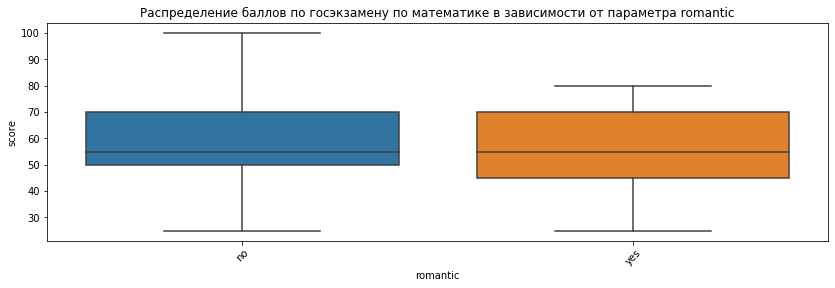

Статистически значимые различия для параметра romantic не найдены


In [50]:
'''Проверка параметра romantic (в романтических отношениях)'''
print('Количество пропущенных значений:',stud_math.romantic.isnull().sum())
display('Количественные показатели:', stud_math.romantic.value_counts())
data_boxplot('romantic')
data_stat_dif('romantic')

### Выводы: 
#### 1. Замечательный подростковый период: ну как можно жить без влюблённости в кого-нибудь (69%)?
#### 2. Данные достаточно полные, пропущенных значений 28 (не все готовы признаться в этом), заполнить их не представляется возможным ввиду отсутствия информации, дополнительной обработки данных не требуется.
#### 3. Статистически значимые различия данных для оценки влияния успеваемости не найдены, поэтому параметр romantic можно исключить из дальнейшего анализа (построения модели)
###  

# УФФФ, я сделал это!!!!!

## Таким образом, для дальнейшего анализа и построения модели мы оставляем следующие параметры:
## - из количественных: age, m_edu, f_edu, study_time, failures, go_out, absences
## - из номинативных: sex, address, m_job, school_sup

In [51]:
stud_math_for_model = stud_math.loc[:, ['age', 'm_edu', 'f_edu', 'study_time', 'failures', 'go_out', 
                                        'absences', 'sex', 'address', 'm_job', 'school_sup']]
stud_math_for_model.head()

,age,m_edu,f_edu,study_time,failures,go_out,absences,sex,address,m_job,school_sup
0,18.00,4.00,4.00,2.00,0.00,4.00,6.00,F,U,at_home,yes
1,17.00,1.00,1.00,2.00,0.00,3.00,4.00,F,U,at_home,no
2,15.00,1.00,1.00,2.00,3.00,2.00,10.00,F,U,at_home,yes
3,15.00,4.00,2.00,3.00,0.00,2.00,2.00,F,U,health,no
4,16.00,3.00,3.00,2.00,0.00,2.00,4.00,F,U,other,no


### Итак, в результате EDA для анализа влияния условий жизни учеников учащихся в возрасте от 15 до 22 лет на их успеваемость по математике были получены следующие выводы:
### В данных относительно мало пропущенных значений, только столбец bean_type был заполнен в малом количестве случаев.
Выбросы найдены только в столбцах с рейтингом и содержанием какао в шоколаде батончиков, что позволяет сделать вывод о том, что данные достаточно чистые.
Положительная корреляция параметра review_date и rating может говорить о том, что с годами рейтинги потихоньку завышаются, либо батончики становятся лучше.
Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это company, specific_origin, company_location, review_date и cocoa_percent.

Параметр school


'Количественные показатели:'

GP    275
MS     39
Name: school, dtype: int64

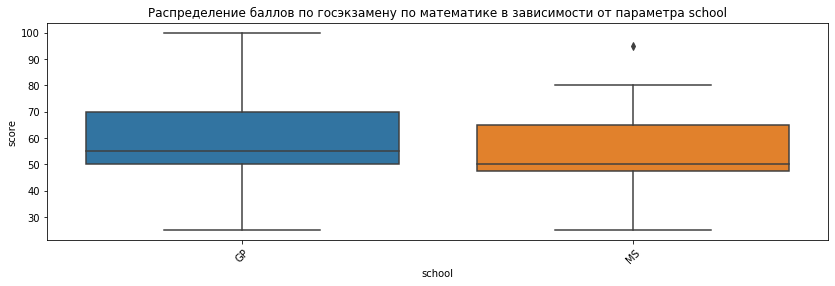

Статистически значимые различия для параметра school не найдены

Параметр sex


'Количественные показатели:'

F    161
M    153
Name: sex, dtype: int64

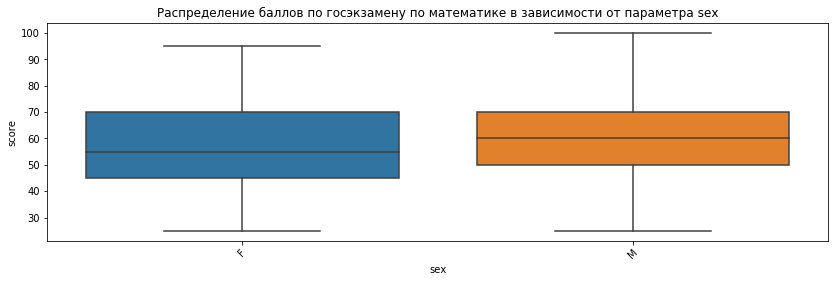

Найдены статистически значимые различия для параметра sex

Параметр address


'Количественные показатели:'

U    235
R     66
Name: address, dtype: int64

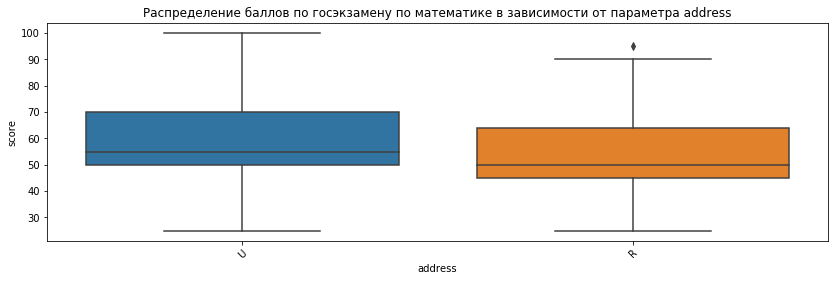

Найдены статистически значимые различия для параметра address

Параметр fam_size


'Количественные показатели:'

GT3    207
LE3     89
Name: fam_size, dtype: int64

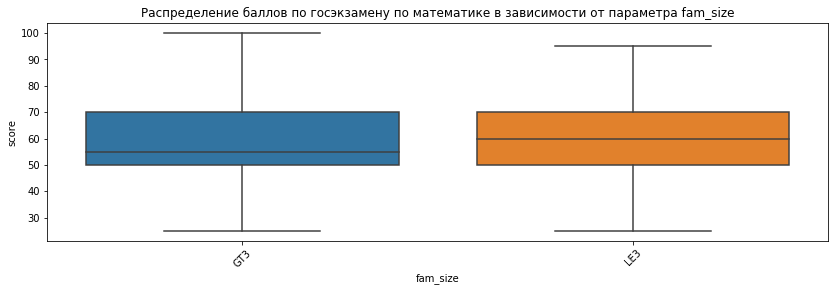

Статистически значимые различия для параметра fam_size не найдены

Параметр p_status


'Количественные показатели:'

T    254
A     28
Name: p_status, dtype: int64

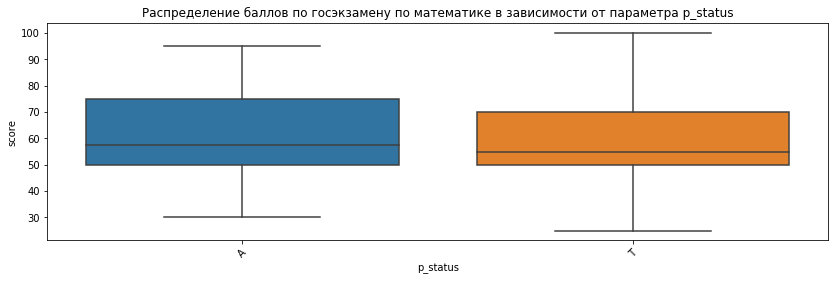

Статистически значимые различия для параметра p_status не найдены

Параметр m_job


'Количественные показатели:'

other       102
services     79
teacher      46
at_home      44
health       29
Name: m_job, dtype: int64

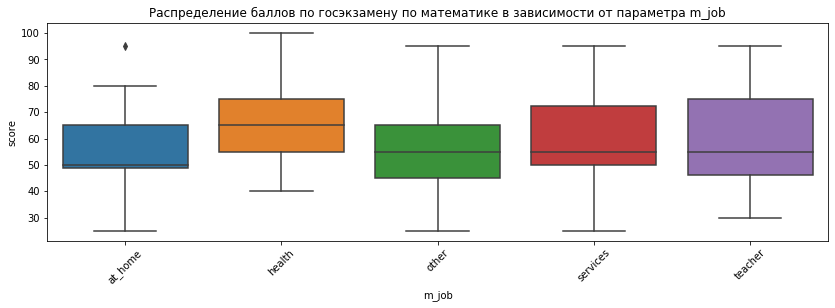

Найдены статистически значимые различия для параметра m_job

Параметр f_job


'Количественные показатели:'

other       159
services     78
teacher      22
at_home      14
health       13
Name: f_job, dtype: int64

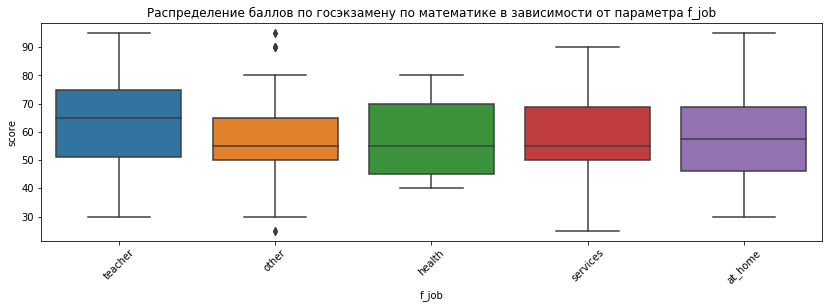

Статистически значимые различия для параметра f_job не найдены

Параметр reason


'Количественные показатели:'

course        110
reputation     84
home           75
other          30
Name: reason, dtype: int64

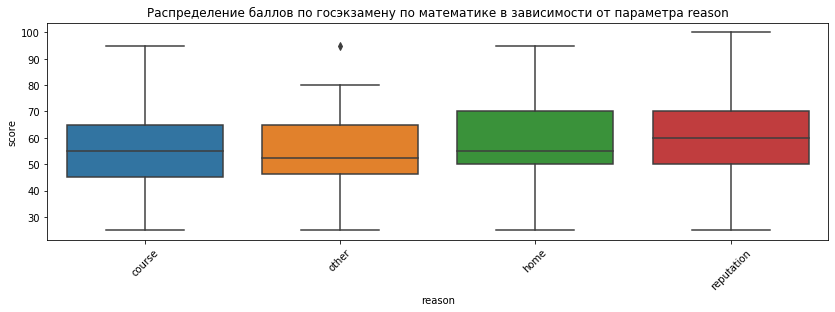

Статистически значимые различия для параметра reason не найдены

Параметр guardian


'Количественные показатели:'

mother    198
father     74
other      14
Name: guardian, dtype: int64

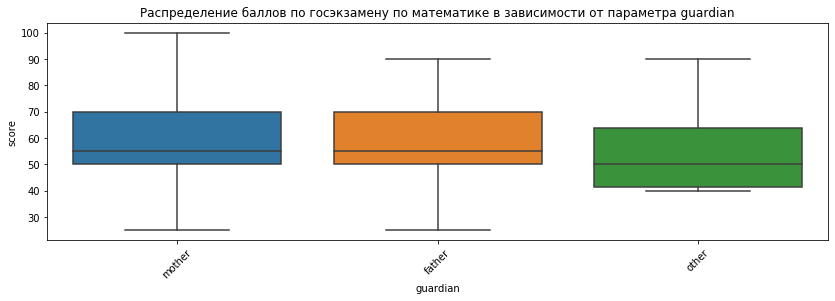

Статистически значимые различия для параметра guardian не найдены

Параметр school_sup


'Количественные показатели:'

no     262
yes     43
Name: school_sup, dtype: int64

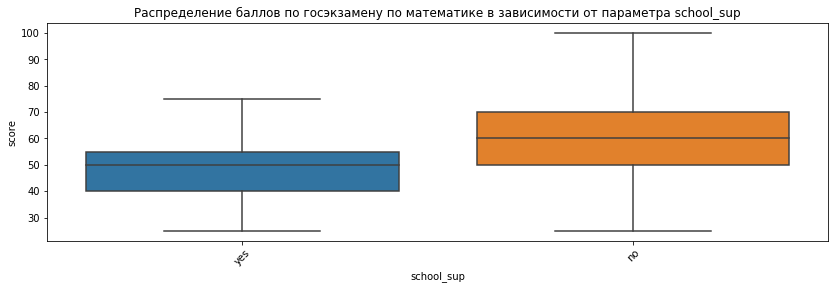

Найдены статистически значимые различия для параметра school_sup

Параметр fam_sup


'Количественные показатели:'

yes    174
no     110
Name: fam_sup, dtype: int64

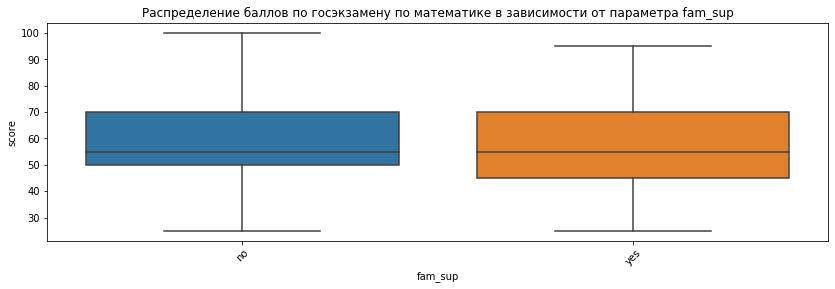

Статистически значимые различия для параметра fam_sup не найдены

Параметр paid


'Количественные показатели:'

no     152
yes    129
Name: paid, dtype: int64

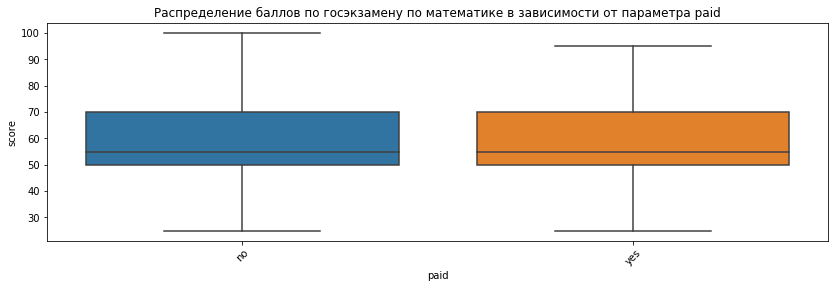

Статистически значимые различия для параметра paid не найдены

Параметр activities


'Количественные показатели:'

yes    158
no     144
Name: activities, dtype: int64

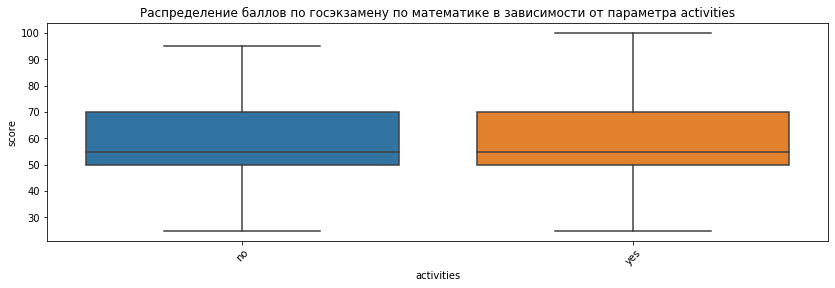

Статистически значимые различия для параметра activities не найдены

Параметр nursery


'Количественные показатели:'

yes    242
no      60
Name: nursery, dtype: int64

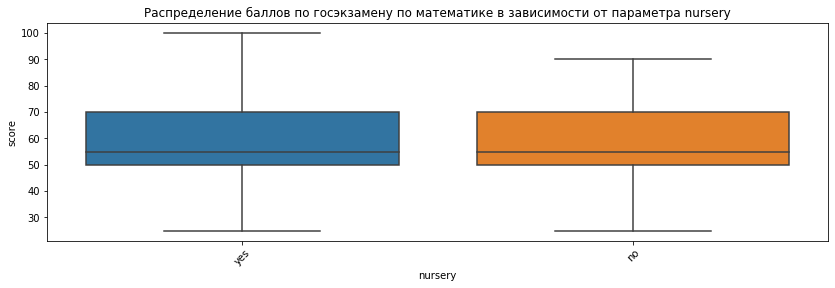

Статистически значимые различия для параметра nursery не найдены

Параметр higher


'Количественные показатели:'

yes    288
no      10
Name: higher, dtype: int64

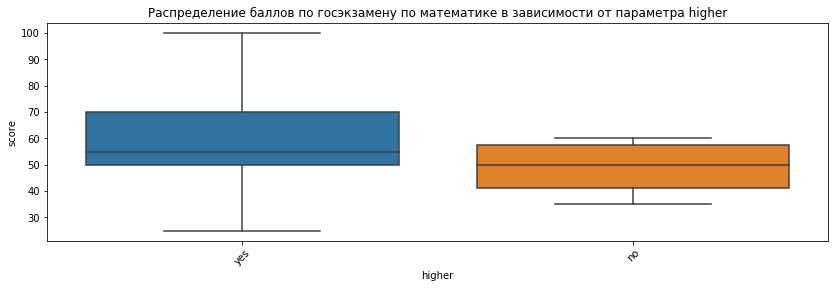

Статистически значимые различия для параметра higher не найдены

Параметр internet


'Количественные показатели:'

yes    241
no      47
Name: internet, dtype: int64

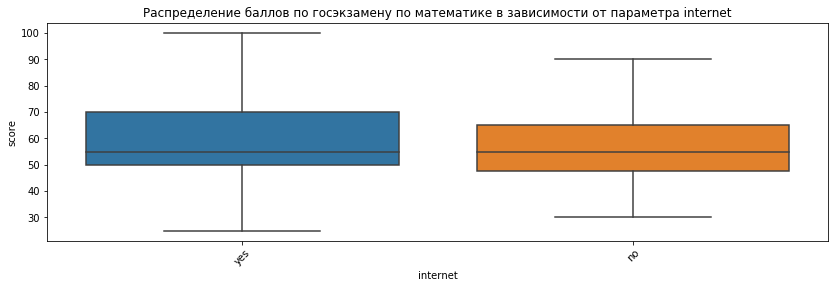

Статистически значимые различия для параметра internet не найдены

Параметр romantic


'Количественные показатели:'

no     197
yes     89
Name: romantic, dtype: int64

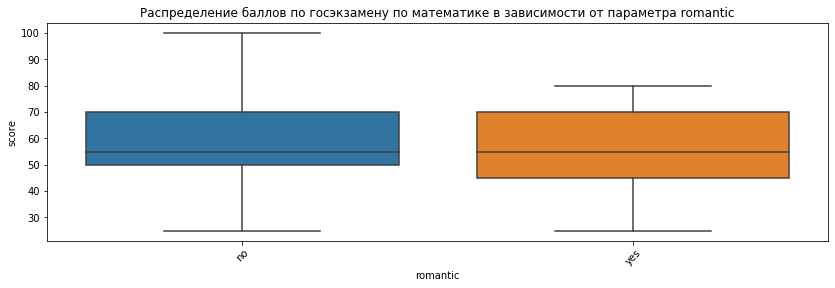

Статистически значимые различия для параметра romantic не найдены



In [52]:
for clmn in stud_math.columns:
    if stud_math.loc[:, clmn].dtype == 'O':
        print('Параметр', clmn)
        display('Количественные показатели:', stud_math.loc[:, clmn].value_counts())
        data_boxplot(clmn)
        data_stat_dif(clmn)
        print(end='=====================================================================\n\n')

In [53]:
for clmn in stud_math.columns:
    if stud_math.loc[:, clmn].dtype == 'O':
        data_stat_dif(clmn)

Статистически значимые различия для параметра school не найдены
Найдены статистически значимые различия для параметра sex
Найдены статистически значимые различия для параметра address
Статистически значимые различия для параметра fam_size не найдены
Статистически значимые различия для параметра p_status не найдены
Найдены статистически значимые различия для параметра m_job
Статистически значимые различия для параметра f_job не найдены
Статистически значимые различия для параметра reason не найдены
Статистически значимые различия для параметра guardian не найдены
Найдены статистически значимые различия для параметра school_sup
Статистически значимые различия для параметра fam_sup не найдены
Статистически значимые различия для параметра paid не найдены
Статистически значимые различия для параметра activities не найдены
Статистически значимые различия для параметра nursery не найдены
Статистически значимые различия для параметра higher не найдены
Статистически значимые различия для параме